Trying to replicate [Prastawa and colleagues (2003)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2430604/).

Create tumor prior
------------------

1. Co-register T1 and T1 contrast-enhanced.
1. Subtract T1 from T1 contrast-enhanced.
1. Use subtracted volume to make a probability mask.

In [1]:
%matplotlib inline

In [133]:
from __future__ import division, print_function

import os.path as op
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy import stats

In [3]:
def plot(arr, title=None):
    """Plot a 2D slice."""
    plt.imshow(arr, cmap='gray', origin='lower')
    if title is not None:
        plt.title(title)
    plt.show()

def transform_0_1(arr):
    """Transform data to range [0, 1]."""
    return (arr - arr.min()) / (arr.max() - arr.min())

In [4]:
data_dir = '/om/user/jakubk/meningioma/data'
subject = 'subj-005'

T1_contrast = '{}_gad-T1w.nii.gz'.format(subject)
T1_contrast_nii = nib.load(op.join(data_dir, subject, 'anat', T1_contrast))
T1_contrast = T1_contrast_nii.get_data()

T1 = '{}_T1w.nii.gz'.format(subject)
T1_nii = nib.load(op.join(data_dir, subject, 'anat', T1))
T1 = T1_nii.get_data()

T1_flirt = '{}_T1w-flirt.nii.gz'.format(subject)  # Registered to T1 contrast.
T1_flirt_nii = nib.load(op.join(data_dir, subject, 'anat', T1_flirt))
T1_flirt = T1_flirt_nii.get_data()

T2 = '{}_T2w.nii.gz'.format(subject)
T2_nii = nib.load(op.join(data_dir, subject, 'anat', T2))
T2 = T2_nii.get_data()

T2_flirt = '{}_T2w-flirt.nii.gz'.format(subject)  # Registered to T1 contrast.
T2_flirt_nii = nib.load(op.join(data_dir, subject, 'anat', T2_flirt))
T2_flirt = T2_flirt_nii.get_data()

In [5]:
print("T1 contrast shape", T1_contrast.shape)
print("T1 shape", T1.shape)
print("T1 FLIRT shape", T1_flirt.shape)
print("T2 shape", T2.shape)
print("T2 FLIRT shape", T2_flirt.shape)

T1 contrast shape (256, 256, 196)
T1 shape (512, 512, 28)
T1 FLIRT shape (256, 256, 196)
T2 shape (512, 512, 28)
T2 FLIRT shape (256, 256, 196)


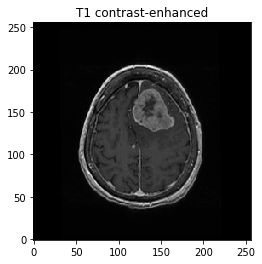

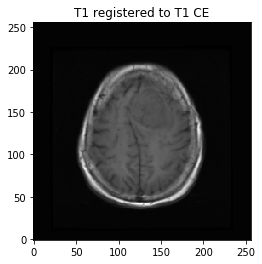

In [6]:
slice_ = 135
plot(T1_contrast[:, :, slice_].T, "T1 contrast-enhanced")
plot(T1_flirt[:, :, slice_].T, "T1 registered to T1 CE")

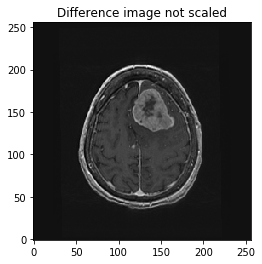

In [7]:
# diff = T1_post - T1_pre
diff = (T1_contrast[:, :, slice_] - T1_flirt[:, :, slice_]).T
plot(diff, "Difference image not scaled")

## Scale the intensity values to [0, 1]

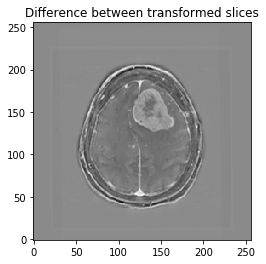

In [18]:
diff = transform_0_1(T1_contrast[:, :, slice_]) - transform_0_1(T1_flirt[:, :, slice_])
plot(diff.T, "Difference between transformed slices")

# plt.hist(diff.flatten())
# plt.title("Histogram of difference of transformed slices")
# plt.show()

## Histogram analysis

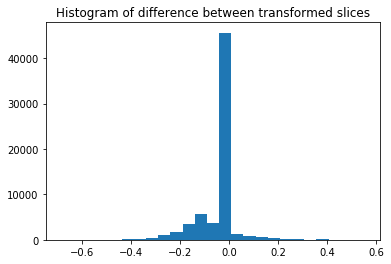

In [341]:
plt.hist(diff.flatten(), bins=25)
plt.title("Histogram of difference between transformed slices")
plt.show()

In [342]:
# Make the different distributions.
mu, sigma = stats.norm.fit(diff.flatten())
fitted_hist = stats.norm(mu, sigma)
wide_gaussian = stats.norm(loc=mu, scale=0.5)
gamma = stats.gamma(a=1.5, loc=mu, scale=.5)

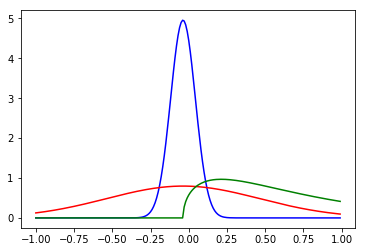

In [348]:
x = np.arange(-1., 1., 0.01)
plt.plot(x, fitted_hist.pdf(x), 'blue');
plt.plot(x, wide_gaussian.pdf(x), color='red');
plt.plot(x, gamma.pdf(x), color='green');

In [307]:
import SimpleITK as sitk

In [44]:
arr1 = transform_0_1(T1_contrast[:, :, slice_])
arr2 = transform_0_1(T1_flirt[:, :, slice_])

img1 = sitk.GetImageFromArray(arr1)
img2 = sitk.GetImageFromArray(arr2)

In [47]:
match_img = sitk.HistogramMatching(img1, img2)

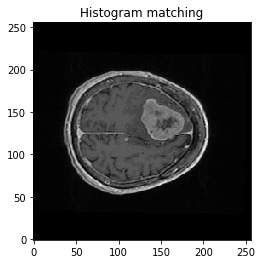

In [49]:
plot(sitk.GetArrayFromImage(match_img), "Histogram matching")